In [29]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Import the libraries of interest for this notebook

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools
import torch
import numpy as np

# Set numpy print format
np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

import tsvar

Set cells width

In [31]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))



---

## Generate toy example dataset


### V1. Small 2-dimensional toy setting

### V2. Larger setting

In [80]:
from experiments_utils import generate_parameters

dim = 100
max_jumps=7e3 * dim

param_dict = generate_parameters(dim=dim)

mu = torch.tensor(param_dict['baseline'])
beta = torch.tensor(param_dict['beta'])
alpha = torch.tensor(param_dict['adjacency'])

print('Baseline:')
print(mu.numpy().round(2))
print('Alpha:')
print(alpha.numpy().round(2))
print('Beta:')
print(beta.numpy().round(2))

Baseline:
[ 0.02  0.02  0.04  0.01  0.03  0.02  0.05  0.03  0.04  0.04  0.05  0.00  0.05  0.04  0.02  0.02  0.04  0.03  0.02  0.01  0.02  0.05  0.01  0.03  0.01  0.03  0.01  0.01  0.04  0.01  0.05  0.04  0.05  0.02  0.02  0.04  0.01  0.03  0.02  0.03  0.05  0.03  0.03  0.04  0.00  0.04  0.04  0.03  0.02  0.01  0.00  0.01  0.02  0.05  0.01  0.00  0.02  0.03  0.00  0.04  0.05  0.02  0.00  0.03  0.04  0.04
  0.04  0.03  0.01  0.02  0.03  0.01  0.01  0.03  0.03  0.04  0.03  0.05  0.00  0.04  0.03  0.03  0.04  0.01  0.02  0.04  0.01  0.03  0.03  0.01  0.04  0.04  0.03  0.03  0.04  0.00  0.04  0.01  0.02  0.04]
Alpha:
[[ 0.00  0.00  0.00 ...  0.00  0.14  0.00]
 [ 0.00  0.00  0.00 ...  0.00  0.00  0.00]
 [ 0.13  0.00  0.00 ...  0.00  0.00  0.00]
 ...
 [ 0.00  0.00  0.00 ...  0.00  0.00  0.00]
 [ 0.00  0.00  0.00 ...  0.00  0.00  0.00]
 [ 0.00  0.00  0.13 ...  0.00  0.00  0.00]]
Beta:
[[ 0.64  0.11  0.96 ...  0.13  0.40  0.50]
 [ 0.19  0.17  0.21 ...  0.63  0.61  0.23]
 [ 0.25  0.55  0.70 ... 

In [81]:
np.abs(np.linalg.eigvals(alpha / (1 + beta))).max()

0.9485856

In [82]:
len(alpha.nonzero()) / (dim ** 2)

0.091

### Simulate a realization

In [83]:
coeffs_true_dict = {
    'baseline': mu.numpy(),
    'adjacency': alpha.numpy(),
    'beta': beta.numpy()
}

coeffs_true = torch.cat((mu, beta.flatten(), alpha.flatten())).numpy()
print('  - Simulate lots of data...')
# Simulate lots of data
wold_sim = tsvar.simulate.MultivariateWoldSimulator(
    mu_a=mu, alpha_ba=alpha, beta_ba=beta)
events = wold_sim.simulate(max_jumps=200000)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]
end_time = max(map(max, events))
print((f"    - Simulated {sum(map(len, events)):,d} events "
       f"with end time: {end_time}"))
print("    - Events:")
for i, events_i in enumerate(events):
    print(f"      - dim {i:>2d} ({len(events_i):>5d} events):", events_i.numpy())

  - Simulate lots of data...
    - Simulated 200,000 events with end time: 4120.05126953125
    - Events:
      - dim  0 ( 3112 events): [   30.46    33.83    36.76 ...  4115.94  4116.56  4116.61]
      - dim  1 ( 1358 events): [   24.59    30.26    44.03 ...  4098.69  4114.50  4118.77]
      - dim  2 ( 2009 events): [    6.10    15.13    46.88 ...  4116.83  4117.28  4119.48]
      - dim  3 ( 3154 events): [   41.57    43.25    44.50 ...  4119.05  4119.65  4119.91]
      - dim  4 ( 1615 events): [    5.56    14.55    16.25 ...  4112.10  4113.72  4118.75]
      - dim  5 ( 1787 events): [    9.75    65.19    67.44 ...  4116.00  4117.65  4117.81]
      - dim  6 ( 2207 events): [    3.79   109.58   113.25 ...  4113.11  4113.90  4119.35]
      - dim  7 ( 1715 events): [   72.73    74.55    85.37 ...  4110.90  4110.91  4115.91]
      - dim  8 ( 1725 events): [    8.14    12.57    18.97 ...  4113.05  4118.13  4119.13]
      - dim  9 ( 2860 events): [   35.51    36.75    38.82 ...  4117.79  41

In [95]:
wmod = tsvar.models.WoldModel()
wmod.observe(events)

deltas = np.hstack(map(np.ravel, wmod.delta_ikj))
median_delta = np.median(deltas)

dts = np.hstack([np.diff(ev) for ev in events])
median_dts = np.median(dts)

print('Delta:')
print('      median:', median_delta)
print('         min:', np.min(deltas))
print('         max:', np.max(deltas))
print('  busca beta:', median_delta / np.exp(1))
print('Dts:')
print('      median:', median_dts)
print('         min:', np.min(dts))
print('         max:', np.max(dts))
print('  busca beta:', median_dts / np.exp(1))

Delta:
      median: 1.4075928
         min: 0.0
         max: 132.24663
  busca beta: 0.5178244428891482
Dts:
      median: 1.2568359
         min: 0.0
         max: 132.24663
  busca beta: 0.46236410233168584


In [88]:
tot_events = np.array(sorted(np.hstack(events)))

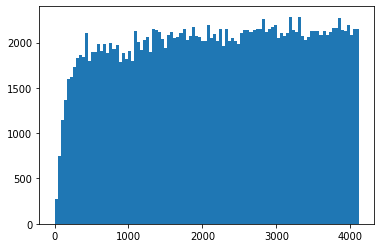

In [89]:
plt.hist(tot_events, bins=100);